In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-base-uncased/config.json
/kaggle/input/bert-base-uncased/pytorch_model.bin
/kaggle/input/bert-base-uncased/vocab.txt
/kaggle/input/ner-dataset/ner_dataset.csv


For running and training model, please find at https://www.kaggle.com/trangdothuy/ner-bilstm-model/notebook

In [2]:
import tensorflow as tf
import keras
from keras.models import Model, Input, Sequential
from keras.layers import LSTM,GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, BatchNormalization, Activation, Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from numpy.random import seed

In [3]:
import torch
import torch.nn as nn
from tqdm import tqdm
import transformers 

import pandas as pd
import numpy as np 

import joblib


from sklearn import preprocessing
from sklearn import model_selection

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [4]:
class Config:
    def __init__(self):
        self.MAX_LEN = 128
        self.TRAIN_BATCH_SIZE = 8
        self.VALID_BATCH_SIZE = 8
        self.EPOCHS = 5
        self.BASE_MODEL_PATH = "../input/bert-base-uncased"
        self.MODEL_PATH = "./model.bin"
        self.TRAINING_FILE = "../input/ner-dataset/ner_dataset.csv"
        self.TOKENIZER = transformers.BertTokenizer.from_pretrained(
                self.BASE_MODEL_PATH,
                do_lower_case=True
            )
config = Config()

In [5]:

def process_data(data_path):
    df = pd.read_csv(data_path,encoding='latin-1')
    df.loc[:,"Sentence #"] = df["Sentence #"].fillna(method="ffill")

    sentences = df.groupby("Sentence #")["Word"].apply(list).values 
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    
    vocab_dict = {'_unk_': 1, '_w_pad_': 0}
    tag_dict = {'_t_pad_': 0}
    
    # add padding token to sentence, and build vocab dict
    padded_sents = []
    for sent in sentences:
        padded_sent = []
        for word in sent:
            padded_sent.append(word)
            if word not in vocab_dict:
                vocab_dict[word] = len(vocab_dict)
        if len(padded_sent) < config.MAX_LEN:
            added_len = config.MAX_LEN - len(padded_sent)
            padded_sent += ['_w_pad_']*added_len
        assert len(padded_sent) == config.MAX_LEN
        padded_sents.append(padded_sent)
        
    # do the same with tag
    tag_seqs = []
    for tag_seq in tag:
        padded_tags = []
        for tag_item in tag_seq:
            padded_tags.append(tag_item)
            if tag_item not in tag_dict:
                tag_dict[tag_item] = len(tag_dict)
        if len(padded_tags) < config.MAX_LEN:
            added_len = config.MAX_LEN - len(padded_tags)
            padded_tags += ['_t_pad_']*added_len
        assert len(padded_tags) == config.MAX_LEN
        tag_seqs.append(padded_tags)
        
    word2idx = vocab_dict
    tag2idx = tag_dict
    
    sent_tokens = np.array([[word2idx[w] for w in doc] for doc in padded_sents])
    tag_tokens = [[tag2idx[t] for t in t_seq] for t_seq in tag_seqs]
    tag_tokens = np.array([to_categorical(t_seq, num_classes=len(tag_dict)) for t_seq in tag_tokens])
    
    return sent_tokens, tag_tokens, word2idx, tag2idx

if __name__ == '__main__':
    sent_tokens, tag_tokens, word2idx, tag2idx = process_data(config.TRAINING_FILE)
    idx2word = {v:k for k,v in word2idx.items()}
    idx2tag = {v:k for k,v in tag2idx.items()} 

In [6]:
(
        train_tokens, 
        val_tokens, 
        train_tags,
        val_tags
     ) = model_selection.train_test_split(sent_tokens, tag_tokens,random_state = 42,test_size = 0.2)



In [7]:
def build_model(max_sent_length, vocab_size, hidden_size, embedding_size, 
                output_size, learning_rate,num_mlp_layers,activation,dropout_rate):
    
    
    inputs = Input(shape=(max_sent_length,), dtype='int32')
    emb = Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    input_length=max_sent_length,
                    embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(inputs)
    
    bilstm_layer_1 = Bidirectional(LSTM(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=True))(emb)
    bilstm_layer_1_dropout = Dropout(dropout_rate, seed=0)(bilstm_layer_1)
    bilstm_layer_2 = Bidirectional(LSTM(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=True))(bilstm_layer_1_dropout)
    bilstm_layer_2_dropout = Dropout(dropout_rate, seed=0)(bilstm_layer_2)

    bilstm_layer_3 = Bidirectional(LSTM(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=True))(bilstm_layer_2_dropout)
    bilstm_layer_3_dropout = Dropout(dropout_rate, seed=0)(bilstm_layer_3)

    bilstm_layer_4 = Bidirectional(LSTM(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=True))(bilstm_layer_3_dropout)
    bilstm_layer_4_dropout = Dropout(dropout_rate, seed=0)(bilstm_layer_4)
    
    h = bilstm_layer_4_dropout
    
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(0.0))(h)
        # add batch normalization layer
        new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    dense = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    model = Model(inputs, dense)
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
                                 
    return model

In [8]:
import csv
from pathlib import Path

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "LSTM_CRF.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

class StepLogCallback(keras.callbacks.Callback):
    def __init__(self):
        self.count = 0
        self.step_log = []
        self.log_fpath = Path('./step_log.csv')
    
    def on_train_batch_end(self, batch, logs=None):
        self.count += 1
        self.step_log.append([self.count, logs['loss'], logs['accuracy']])
    
    def on_epoch_end(self, epoch, logs=None):
        log_exists = self.log_fpath.exists()
        with open(self.log_fpath, 'a' if log_exists else 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if not log_exists:
                writer.writerow(['step','loss','accuracy'])
            for log in self.step_log:
                writer.writerow(log)
            self.step_log.clear()

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data, ground_file, model):
        self.count = 0
        self.test_data = test_data
        self.model = model
        self.ground_file = ground_file
        self.epoch_log = []
        self.log_fpath = Path('./epoch_log.csv')
        
    def calc_accuracy(self, preds, tags, padding_id="_t_pad_"):
        preds_flatten = preds.flatten()
        tags_flatten = tags.flatten()
        non_padding_idx = np.where(tags_flatten!=padding_id)[0]
        return sum(preds_flatten[non_padding_idx]==tags_flatten[non_padding_idx])/len(non_padding_idx)
        
    def on_epoch_end(self, epoch, logs=None):
        val_preds_numerical = self.model.predict(self.test_data)
        val_preds = np.array([[idx2tag[p] for p in preds] for preds in np.argmax(val_preds_numerical,axis=2)])
        file_dict = pkl.load(open(self.ground_file, "rb"))
        val_accuracy = self.calc_accuracy(val_preds, np.array(file_dict["tag_seq"]))
        
        print('\nValidation Set Accuracy: %f\n' % val_accuracy)
        
        self.count += 1
        log_exists = self.log_fpath.exists()
        with open(self.log_fpath, 'a' if log_exists else 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if not log_exists:
                writer.writerow(['epoch','loss','train_accuracy','val_accuracy'])
            writer.writerow([self.count, logs['loss'], logs['accuracy'], val_accuracy])
            self.epoch_log.clear()

In [9]:
input_length = config.MAX_LEN
vocab_size = len(word2idx)
hidden_size = 100
embedding_size = 300
output_size = train_tags.shape[2]
learning_rate = 0.0001
num_mlp_layers = 3
activation = "tanh"
dropout_rate = 0.5

In [10]:
np.random.seed(0)
tf.random.set_seed(0)
model = build_model(input_length, vocab_size, hidden_size, embedding_size, 
                    output_size, learning_rate, num_mlp_layers, activation, dropout_rate)
model.summary()

2021-12-20 08:50:25.935527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 08:50:25.937084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 08:50:25.938186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 08:50:25.939476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 300)     10554000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128, 200)     320800      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 200)     0           bidirectional[0][0]              
______________________________________________________________________________________________

In [11]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('rnn-ner-training.log', append=False)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

In [12]:
!rm -f *.csv
history = model.fit(train_tokens, train_tags,
                    batch_size=128, epochs=20, validation_data = (val_tokens, val_tags),
                    callbacks=[checkpointer,csv_logger])

2021-12-20 08:50:35.343807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-20 08:50:48.261980: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


300/300 [==============================] - 54s 129ms/step - loss: 0.2102 - accuracy: 0.9577 - val_loss: 0.1271 - val_accuracy: 0.9737


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
300/300 [==============================] - 35s 116ms/step - loss: 0.1256 - accuracy: 0.9738 - val_loss: 0.1205 - val_accuracy: 0.9737
Epoch 3/20
300/300 [==============================] - 35s 117ms/step - loss: 0.0936 - accuracy: 0.9760 - val_loss: 0.0567 - val_accuracy: 0.9819
Epoch 4/20
300/300 [==============================] - 35s 116ms/step - loss: 0.0472 - accuracy: 0.9849 - val_loss: 0.0385 - val_accuracy: 0.9887
Epoch 5/20
300/300 [==============================] - 35s 117ms/step - loss: 0.0316 - accuracy: 0.9909 - val_loss: 0.0309 - val_accuracy: 0.9914
Epoch 6/20
300/300 [==============================] - 35s 117ms/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 0.0254 - val_accuracy: 0.9932
Epoch 7/20
300/300 [==============================] - 35s 118ms/step - loss: 0.0186 - accuracy: 0.9951 - val_loss: 0.0241 - val_accuracy: 0.9937
Epoch 8/20
300/300 [==============================] - 35s 116ms/step - loss: 0.0157 - accuracy: 0.9958 - val_loss: 0.0243 - val_ac

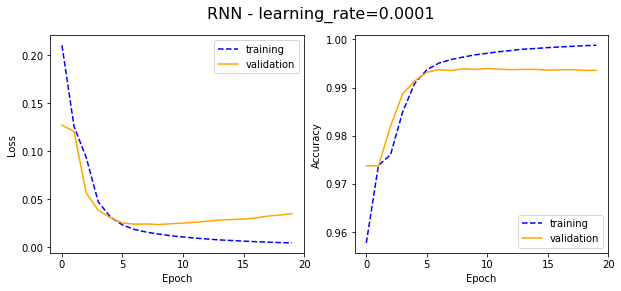

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.suptitle("RNN - learning_rate=0.0001", fontsize=16)
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_loss"], label="validation", color="orange")
plt.xticks((0,5,10,15,20))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_accuracy"], label="validation", color="orange")
plt.xticks((0,5,10,15,20))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
# save model
model.save('models/BiLSTM_model.h5')

## Prediction

In [15]:
model =  keras.models.load_model('models/BiLSTM_model.h5')


In [16]:
sentence = "HKUST honors faculty and staff members who have served the University for at least two decades."
sent = sentence.split(" ")
encoded_sent = []
for word in sent:
    if word in word2idx:
        encoded_sent.append(word2idx[word])
    else:
        encoded_sent.append(1)
if len(encoded_sent) < config.MAX_LEN:
    encoded_sent += [0]*(config.MAX_LEN - len(encoded_sent))
assert len(encoded_sent) == config.MAX_LEN

test_dataset = []
test_dataset.append(encoded_sent)
test_dataset = np.array(test_dataset)
test_preds_numerical = model.predict(test_dataset)
test_preds = np.array([[idx2tag[p] for p in preds] for preds in np.argmax(test_preds_numerical,axis=2)])
print(test_preds.shape)
print(test_preds[0])

(1, 128)
['O' 'O' 'B-org' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-org' 'O' 'O' 'O' 'B-tim'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_'
 '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_pad_' '_t_p